# House Prices Prediction

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score
import lightgbm as lgb

from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit

### Read Data

In [2]:
training_set_path = '../dataset/train.csv'
train0 = pd.read_csv(training_set_path)

testing_set_path = '../dataset/test.csv'
test0 = pd.read_csv(testing_set_path)

## Cleaning

### Drop Outlier

In [3]:
train1 = train0[train0.GrLivArea < 4500]
train1.dropna(axis=0, subset=['MasVnrArea', 'Electrical'], inplace=True)
train1.reset_index(drop=True, inplace=True)

## EDA

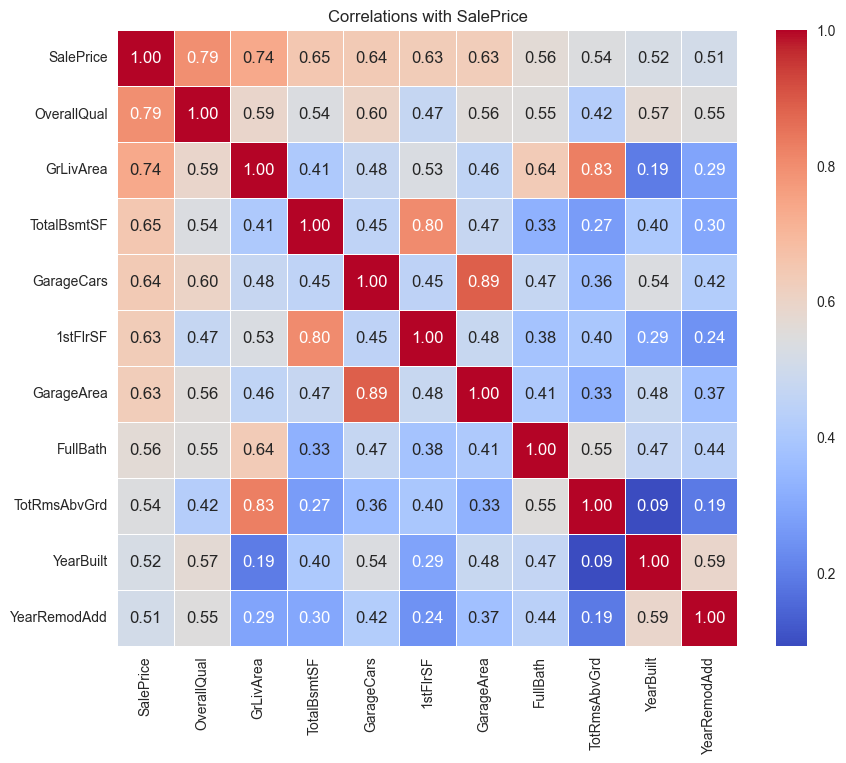

In [4]:
numeric = train1.select_dtypes(include=[np.number])
corr_numeric = numeric.corr()
corr_sorted = corr_numeric['SalePrice'].sort_values(ascending=False)
corr_high = corr_sorted[abs(corr_sorted) > 0.5].index
corr_numeric = corr_numeric.loc[corr_high, corr_high]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_numeric, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlations with SalePrice')
plt.show()

From the above graph, we can observe that some of the columns have a high correlation:
- GarageArea and GarageCars: 0.89.
- TotRmsAbvGrd and GrLivArea: 0.83.
- 1stFlrSF and TotalBsmtSF: 0.8.
In order to improve the model and reduce multicollinearity, feature engineering is needed for these columns

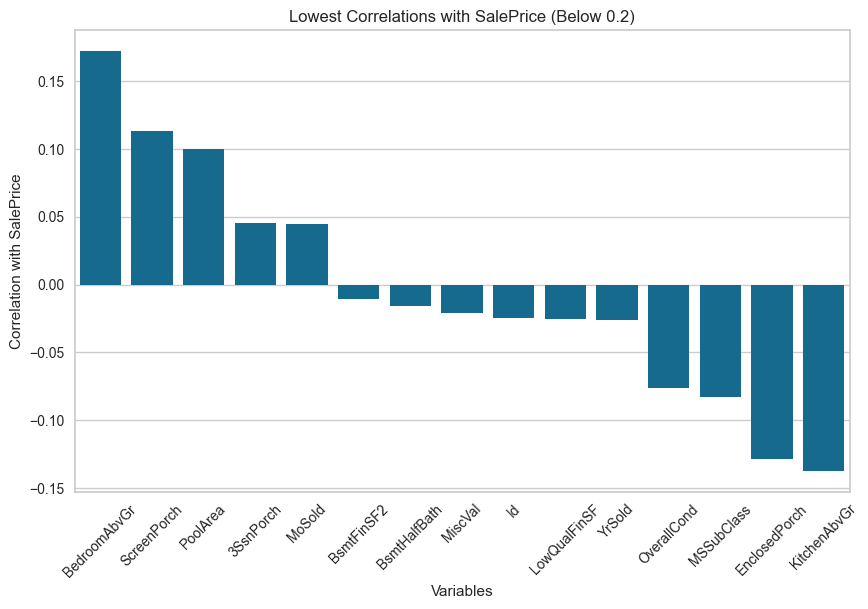

In [5]:

low_corr = corr_sorted[abs(corr_sorted) < 0.2]

# Plotting lowest correlations with SalePrice
plt.figure(figsize=(10, 6))
sns.barplot(x=low_corr.index, y=low_corr.values)
plt.title('Lowest Correlations with SalePrice (Below 0.2)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xlabel('Variables')
plt.ylabel('Correlation with SalePrice')
plt.show()

Feature engineering will be apply to the above columns.
If not applicable for feature engineering, columns will be dropped.

### Concrat train and test set

In [6]:
y = train1['SalePrice']
test_ids = test0['Id']

train1.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test0.drop(['Id'], axis=1, inplace=True)

data1 = pd.concat([train1, test0], axis=0).reset_index(drop=True)
data1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2903,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2904,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2905,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2906,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


## Drop Numeric Columns 
- low correlation with 'SalePrice' and not applicable for features engineering
- High correlation with other column

In [7]:
data2 = data1.copy()

In [8]:
#low correlation with 'SalePrice' and not applicable for features engineering
data2.drop(['MiscVal', 'LowQualFinSF', 'BsmtFinSF2'], axis=1, inplace=True)

In [9]:
#High correlation
#data2.drop(['TotRmsAbvGrd'], axis=1, inplace=True)

### Set data type as str

In [10]:
data2['MSSubClass'] = data2['MSSubClass'].astype(str)

### Fill Missing Value (Catagorical)

In [11]:
#For these columns, missing value means the feature is not available. So 'None' is filled, which is easier for future features engineering.
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data2[column] = data2[column].fillna("None")

#In the data description document, these columns are not supposed to contain missing value.
#Therefore, we are filling the mode of the column as the missing value
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])

### Fill Missing Value (Numeric)

In [12]:
for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
]:
    data2[column] = data2[column].fillna(0)

## Features Engineering

### Combining Features
Avoiding multicollinearity

In [13]:
data3 = data2.copy()

In [14]:
data3['HighQualFlrSF'] = data3['1stFlrSF'] + data3['2ndFlrSF']

data3['TotalBath'] = data3['FullBath'] + data3['HalfBath'] * 0.5 + data3['BsmtFullBath'] + data3['BsmtHalfBath'] * 0.5

data3['OverallRate'] = data3['OverallQual'] + data3['OverallCond']
data3['TotalPorch'] = data3['OpenPorchSF'] + data3['EnclosedPorch'] + data3['3SsnPorch'] + data3['ScreenPorch']

data3['haspool'] = data3['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data3['hasgarage'] = data3['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data3['hasbsmt'] = data3['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data3['hasfireplace'] = data3['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


#Drop columns which have combined
data3 = data3.drop('1stFlrSF', axis=1)
data3 = data3.drop('2ndFlrSF', axis=1)

data3 = data3.drop('FullBath', axis=1)
data3 = data3.drop('HalfBath', axis=1)
data3 = data3.drop('BsmtFullBath', axis=1)
data3 = data3.drop('BsmtHalfBath', axis=1)

data3 = data3.drop('OverallQual', axis=1)
data3 = data3.drop('OverallCond', axis=1)

data3 = data3.drop('OpenPorchSF', axis=1)
data3 = data3.drop('EnclosedPorch', axis=1)
data3 = data3.drop('3SsnPorch', axis=1)
data3 = data3.drop('ScreenPorch', axis=1)

### Binary Transformation

In [15]:
#Convert the columns 'CentralAir' from (Y/N) to (1/0)
data3['CentralAir'] = data3['CentralAir'].replace({'Y': 1, 'N': 0})

#Convert the data in the column 'Street' to binary, where 'Pave' to 1 and 'Grvl' to 0.
data3['Street'] = data3['Street'].replace({'Pave': 1, 'Grvl': 0})

#Convert the data in the column 'Alley' to binary.
#The way of doing it is to group 'Pave' and 'Grvl'
#If the property has an alley access, then 1; 
#Otherwise 0.
data3['Alley'] = data3['Alley'].replace({'Pave': 1, 'Grvl': 1, 'None': 0})

#Convert the data in the column 'LotShape' to binary, where 'Reg' to 1 and grouping 'IR1', 'IR2' and 'IR3' to 0.
#If the shape of the property is regular, then 1;
#Otherwise 0.
data3['LotShape'] = data3['LotShape'].replace({'Reg': 1, 'IR1': 0, 'IR2': 0, 'IR3': 0})

#Convert the data in the column 'LandContour' to binary, where 'Lvl' to 1 and grouping 'Bnk', 'HLS' and 'Low' to 0.
#If the property is near flat/level, then 1;
#Otherwise 0.
data3['LandContour'] = data3['LandContour'].replace({'Lvl': 1, 'Bnk': 0, 'HLS': 0, 'Low': 0})

#Convert the data in the column 'Utilities' to binary, where 'AllPub' to 1 and grouping 'NoSewr', 'NoSeWa' and 'ELO' to 0.
#If all type of utilities is available, then 1;
#Otherwise 0.
data3['Utilities'] = data3['Utilities'].replace({'AllPub': 1, 'NoSewr': 0, 'NoSeWa': 0, 'ELO': 0})

### Ordinal Encoding

In [16]:
data4 = data3.copy()

In [17]:
#Define the desired order for each categorical feature
LandSlope_order = ['Sev', 'Mod', 'Gtl']
ExterQual_order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
ExterCond_order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
BsmtQual_order = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
BsmtCond_order = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
BsmtExposure_order = ['None', 'No', 'Mn', 'Av', 'Gd']
BsmtFinType1_order = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
BsmtFinType2_order = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
HeatingQC_order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
KitchenQual_order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
Functional_order = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
FireplaceQu_order = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
GarageFinish_order = ['None', 'Unf', 'RFn', 'Fin']
GarageQual_order = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
GarageCond_order = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
PavedDrive_order = ['N', 'P', 'Y']
PoolQC_order = ['None', 'Fa', 'TA', 'Gd', 'Ex']
Fence_order = ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

# List of columns to transform
columns_to_transform_OE = [
    'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence'
]

# Convert specified columns to strings
data4[columns_to_transform_OE] = data4[columns_to_transform_OE].astype(str)

# Create an instance of OrdinalEncoder with specified categories
ordinal_encoder = OrdinalEncoder(categories=[
    LandSlope_order,
    ExterQual_order,
    ExterCond_order,
    BsmtQual_order,
    BsmtCond_order,
    BsmtExposure_order,
    BsmtFinType1_order,
    BsmtFinType2_order,
    HeatingQC_order,
    KitchenQual_order,
    Functional_order,
    FireplaceQu_order,
    GarageFinish_order,
    GarageQual_order,
    GarageCond_order,
    PavedDrive_order,
    PoolQC_order,
    Fence_order
])

# Apply the encoder to the specified columns
encoded_columns_OE = ordinal_encoder.fit_transform(data4[columns_to_transform_OE])

# Create a new DataFrame with encoded values
OE_df = pd.DataFrame(encoded_columns_OE, columns=columns_to_transform_OE)

clean_set_dropped = data4.drop(columns=columns_to_transform_OE)

data4 = pd.concat([clean_set_dropped, OE_df], axis=1)

### Catagorical Variables

In [18]:
data5 = data4.copy()

In [19]:
data5 = pd.get_dummies(data5)

### Date Columns

### Cyclical Encoding (MoSold)

In [20]:
data6 = data5.copy()

In [21]:
data6['MoSold'] = -np.cos((2 * np.pi / 12) * data6['MoSold'])

### Year Difference (YrSold)

In [22]:
data6['YrSold'] = 2010 - data6['YrSold']

In [23]:
data7 = data6.copy()

## Split the data

In [24]:
train_split = data7.loc[:train1.index.max(), :].copy()
test_split = data7.loc[train1.index.max() + 1:, :].reset_index(drop=True).copy()

## Scaling

Scaling after the split to prevent data leakage

In [25]:
scaler = StandardScaler()
scaler.fit(train_split)

train_final = pd.DataFrame(scaler.transform(train_split), index = train_split.index, columns = train_split.columns)
test_final = pd.DataFrame(scaler.transform(test_split), index = test_split.index, columns = test_split.columns)

## Y Transformation

In [26]:
log_y = np.log(y)

## Model Selection

In [27]:
#_ = setup(data = pd.concat([train_final, log_y], axis = 1), target = 'SalePrice')

In [28]:
#compare_models()

br
omp
gbr
ridge
lightgbm
et
rf

## Bagging Ensemble

In [29]:
models = {
    "gbr": GradientBoostingRegressor(verbose=0),
    "br": BayesianRidge(),
    "omp": OrthogonalMatchingPursuit(),
    "et": ExtraTreesRegressor(),
    "ridge": Ridge()
}

In [30]:
for name, model in models.items():
    model.fit(train_final, log_y)
    print(name + " trained.")

gbr trained.
br trained.
omp trained.
et trained.
ridge trained.


## Evaluate

In [31]:
results = {}

kf = KFold(n_splits = 10)

for name, model in models.items():
    result = np.exp(np.sqrt(- cross_val_score(model, train_final, log_y, scoring = 'neg_mean_squared_error', cv = kf)))
    results[name] = result

In [ ]:
results

In [ ]:
for name, model in results.items():
    print(name)
    print(np.mean(result))
    print(np.std(result))

## Combine Predictions

In [32]:
final_predictions = (
    0.2 * np.exp(models['gbr'].predict(test_final)) +
    0.2 * np.exp(models['br'].predict(test_final)) +
    0.2 * np.exp(models['omp'].predict(test_final)) +
    0.2 * np.exp(models['et'].predict(test_final)) +
    0.2 * np.exp(models['ridge'].predict(test_final)) 
)

## Submission

In [33]:
submission4 = pd.concat([test_ids, pd.Series(final_predictions, name = 'SalePrice')], axis = 1)

In [34]:
submission4.to_csv('./submission4.csv', index = False, header = True)

In [33]:
#01: 0.14094
#02: 0.13341
#03: 0.13175
#04: 0.13330

